# Deletion analyses: SheepGut

We've got a few goals here:

1. Identify "deletion-rich" contigs, aka those that have many "deletion-rich" positions. (And I guess there are many ways to classify a position as deletion-rich, so we use a few different thresholds.)

2. Identify "deletion-rich" reads, aka those that have lots of deletions in their CIGAR strings.

We'll use the TSV files we just generated to create plots about these things.

In [23]:
import pysam
import pysamstats
import pandas as pd
from math import log
from matplotlib import pyplot
pyplot.style.use("ggplot")

In [2]:
# bf = pysam.AlignmentFile("/Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")
FASTA_FP = "/Poppy/mfedarko/sheepgut/main-workflow/output/all_edges.fasta"

## 1. Deletion-rich contigs

### Load SheepGut data

In [3]:
# Load the diversity index information in order to get length/coverage info
di = pd.read_csv("output/call-p15/diversity-indices.tsv", sep="\t", index_col=0)
di.head()

,AverageCoverage,Length,"DivIdx(p=25,minSuffCov=2000.0)","DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,,
edge_1,460.398484,39565,NaN,NaN,NaN,0.00889,0.007611,0.004804,0.002604,0.0
edge_2,63.644295,745,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0
edge_3,258.569823,38161,NaN,NaN,NaN,NaN,0.008092,0.006793,0.004086,0.0
edge_4,187.858268,1397,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
edge_5,3.356588,32079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Information about deletion-rich positions in contigs
cdf = pd.read_csv("output/deletion-data/contig-info.tsv", sep="\t", index_col=0)
cdf.head()

,5DelPos,10DelPos,25DelPos,50DelPos,100DelPos,200DelPos,500DelPos,1000DelPos
Contig,,,,,,,,
edge_1,1017,251,30,17,17,15,0,0
edge_2,1,0,0,0,0,0,0,0
edge_3,1105,792,613,587,586,574,0,0
edge_4,17,1,0,0,0,0,0,0
edge_5,0,0,0,0,0,0,0,0


In [5]:
# sanity check
assert (cdf.index == di.index).all()

In [10]:
print(
    f"BACT2 (edge_2358) has len {di['Length']['edge_2358']:,} bp; and "
    f"{cdf['500DelPos']['edge_2358']:,} positions with \u2265 500 deletions."
)

BACT2 (edge_2358) has len 2,806,161 bp; and 591 positions with ≥ 500 deletions.


In [11]:
di_long = di[di["Length"] >= 1000000]
cdf_long = cdf.loc[di_long.index]
assert len(di_long) == len(cdf_long) == 468
assert (di_long.index == cdf_long.index).all()

### Load ChickenGut data

In [12]:
di_cg = pd.read_csv("/Poppy/mfedarko/chicken-gut-meta/sf/call-r-minr3/diversity-indices.tsv", sep="\t", index_col=0)
cdf_cg = pd.read_csv("../chicken/output/deletion-data/contig-info.tsv", sep="\t", index_col=0)
di_cg_long = di_cg[di_cg["Length"] >= 1000000]
cdf_cg_long = cdf_cg.loc[di_cg_long.index]
assert (di_cg_long.index == cdf_cg_long.index).all()

### Histograms of fractions of "deletion-rich" positions

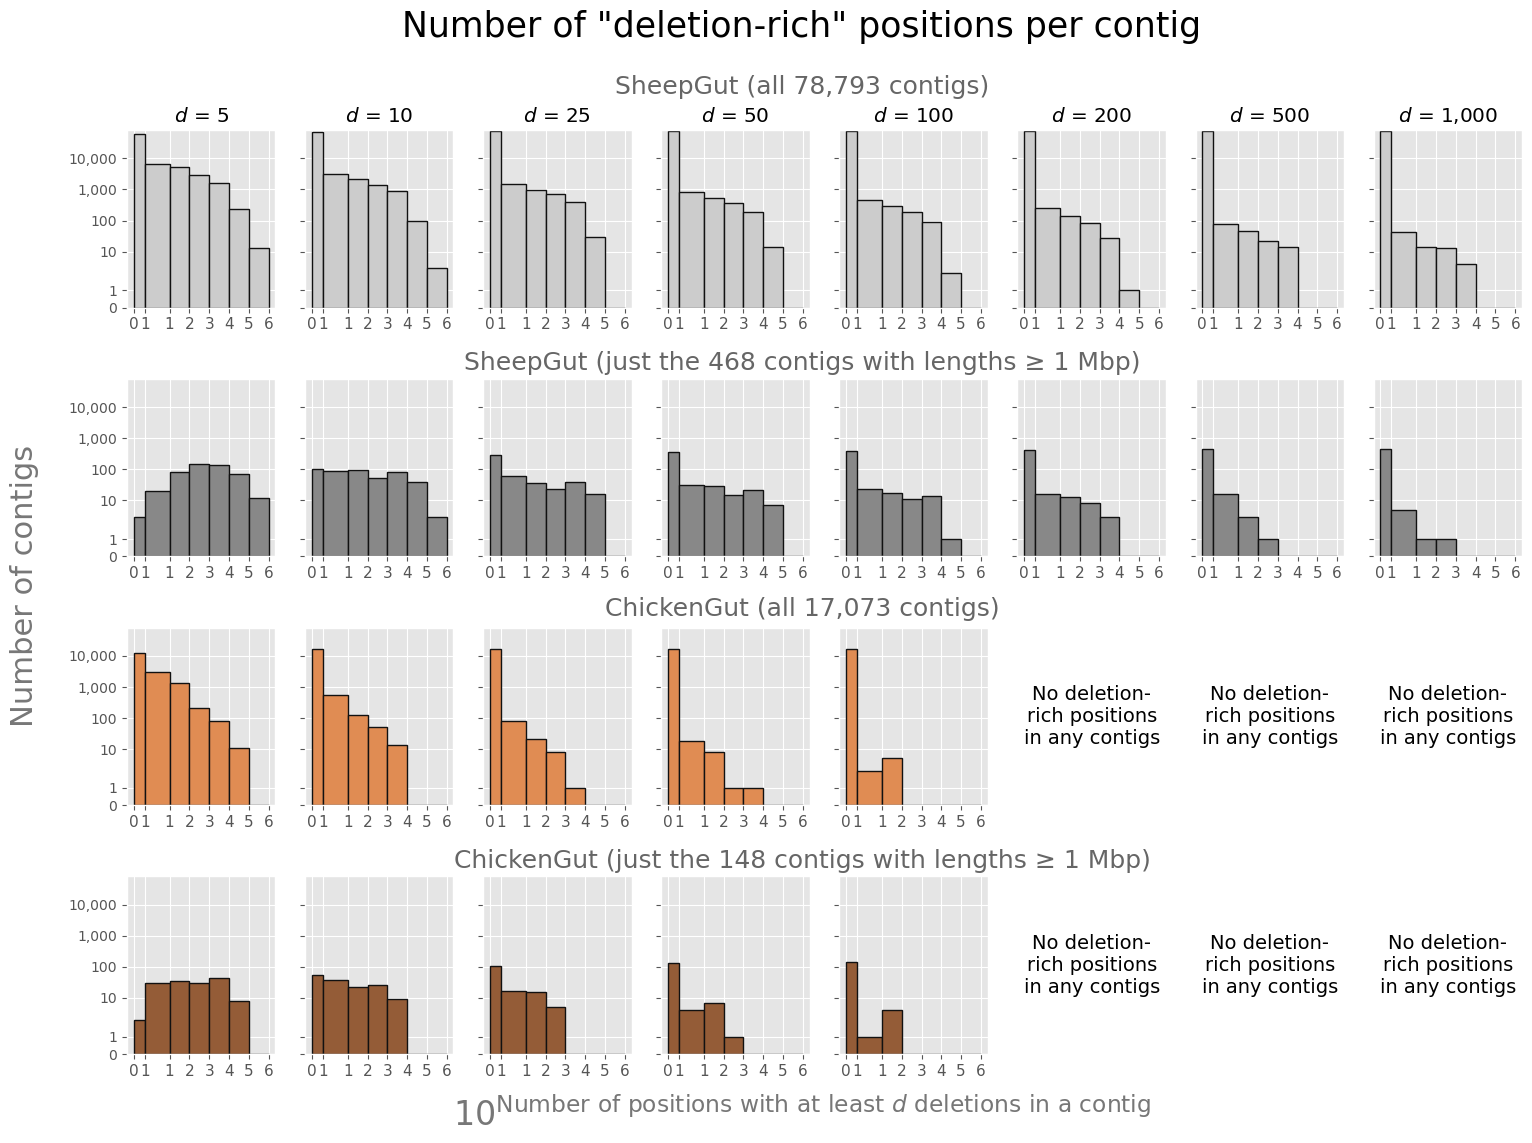

In [46]:
fig, axes = pyplot.subplots(4, 8, gridspec_kw={"hspace": 0.4}, sharey=True)
MAX_X = 32
hist_kwargs = {"edgecolor": "#111", "linewidth": 1, "bins": [0, 1, 10, 100, 1000, 10000, 100000, 1000000]}

def get_10_exp(x, pos):
    # guarantee that x is an integer (maybe it's, like, 10.0000001 or whatevs due to floating-pt stuff)
    assert x - round(x) <= 1e-5
    if x <= 1:
        return f"{int(x)}"
    else:
        # and assert that x is one of the powers of 10.
        # there's probably a more elegant way to do this but this paper is 87 pages my dude
        lx = log(x, 10)
        assert lx - round(lx) <= 1e-5
        return f"{round(log(x, 10))}"

def plot_if_nonzero(df_col, ax, color):
    if (df_col == 0).all():
        # hide the axis background, ticks, etc -- https://stackoverflow.com/a/10035974
        ax.axis("off")
        # ... and show some text instead -- based on the "middle" example at
        # https://matplotlib.org/stable/tutorials/text/text_props.html
        ax.text(0.5, 0.5, "No deletion-\nrich positions\nin any contigs", ha="center", va="center", fontsize=14, transform=ax.transAxes)
    else:
        ax.hist(df_col, color=color, **hist_kwargs)
        assert (df_col < 1e6).all()
        ax.tick_params(axis="x", labelsize=11)

for ci, col in enumerate(cdf.columns):
    plot_if_nonzero(cdf[col], axes[0, ci], "#ccc")
    plot_if_nonzero(cdf_long[col], axes[1, ci], "#888")
    axes[0, ci].set_title(f"$d$ = {int(col[:-6]):,}")
    
for ci, col in enumerate(cdf_cg.columns):
    plot_if_nonzero(cdf_cg[col], axes[2, ci], "#e08c53")
    plot_if_nonzero(cdf_cg_long[col], axes[3, ci], "#945c37")
    
# every-plot settings
for ci in range(len(cdf.columns)):
    for ri in range(4):
        axes[ri, ci].set_xscale("symlog")
        axes[ri, ci].set_yscale("symlog")
        axes[ri, ci].xaxis.set_major_formatter(get_10_exp)
        axes[ri, ci].yaxis.set_major_formatter("{x:,.0f}")

        
rh_kwargs = {"ha": "center", "fontsize": 18, "color": "#666"}
fig.text(0.5, 0.91, f"SheepGut (all {len(cdf.index):,} contigs)", **rh_kwargs)
fig.text(0.5, 0.68, f"SheepGut (just the {len(cdf_long.index):,} contigs with lengths \u2265 1 Mbp)", **rh_kwargs)
fig.text(0.5, 0.475, f"ChickenGut (all {len(cdf_cg.index):,} contigs)", **rh_kwargs)
fig.text(0.5, 0.265, f"ChickenGut (just the {len(cdf_cg_long.index):,} contigs with lengths \u2265 1 Mbp)", **rh_kwargs)
        
fig.text(0.5, 0.05, r"$10^{\mathrm{Number\ of\ positions\ with\ at\ least}\ d\ \mathrm{deletions\ in\ a\ contig}}$", fontsize=24, color="#777", ha="center")
fig.text(0.06, 0.5, "Number of contigs", fontsize=22, color="#777", rotation="vertical", va="center")

fig.suptitle('Number of "deletion-rich" positions per contig', fontsize=25, y=0.98)
fig.set_size_inches(18, 12)
fig.savefig("../../notebooks/figs/deletion_rich_positions.pdf")

In [227]:
di.loc["edge_6104"] < di.loc["edge_11863"]

AverageCoverage                   False
Length                             True
DivIdx(p=25,minSuffCov=2000.0)    False
DivIdx(p=50,minSuffCov=1000.0)     True
DivIdx(p=100,minSuffCov=500.0)     True
DivIdx(p=200,minSuffCov=250.0)     True
DivIdx(p=500,minSuffCov=100.0)     True
DivIdx(p=1000,minSuffCov=50.0)     True
DivIdx(p=2500,minSuffCov=20.0)     True
DivIdx(p=5000,minSuffCov=10.0)     True
dtype: bool

In [124]:
cdf_long.sort_values(["100DelPos"])

,5DelPos,10DelPos,25DelPos,50DelPos,100DelPos,200DelPos,500DelPos,1000DelPos
Contig,,,,,,,,
edge_8,4794,2115,88,0,0,0,0,0
edge_11396,7334,5907,1017,0,0,0,0,0
edge_11266,10302,8105,937,0,0,0,0,0
edge_11258,202,0,0,0,0,0,0,0
edge_11256,7622,6,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
edge_1671,208760,108300,42978,15526,4405,2,0,0
edge_4760,33345,27087,15342,7603,7313,2107,3,0
edge_3030,129464,55825,18804,14262,7332,92,6,6


In [122]:
di["AverageCoverage"]["edge_4773"]

1176.24972747921

In [66]:
ratios.sort_values()

Contig
edge_1        0.000000
edge_52527    0.000000
edge_52526    0.000000
edge_52525    0.000000
edge_52524    0.000000
                ...   
edge_9751     0.395026
edge_25343    0.710941
edge_7309     0.875067
edge_47404    1.212121
edge_61155    1.561403
Length: 78793, dtype: float64

In [141]:
def get_covs_and_dels(contig, bam_fp="/Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam"):
    bf = pysam.AlignmentFile(bam_fp, "rb")
    covs = []
    dels = []
    print(f"Length of {contig} is {di['Length'][contig]:,} bp; avg cov is {di['AverageCoverage'][contig]:,}x.")
    for pos, rec in enumerate(
        pysamstats.stat_variation(bf, chrom=contig, fafile=FASTA_FP, pad=True, max_depth=100000000)
    ):
        if pos % 10000 == 0:
            print(f"On 0-idx'd pos {pos:,}.")
        covs.append(rec["A"] + rec["C"] + rec["G"] + rec["T"])
        dels.append(rec["deletions"])
    print("Done.")
    return covs, dels

In [114]:
covs, dels = get_covs_and_dels("edge_61155")

Length of edge_61155 is 29,909 bp; avg cov is 657.7800996355612x.
On 0-idx'd pos 0.
On 0-idx'd pos 10,000.
On 0-idx'd pos 20,000.
Done.


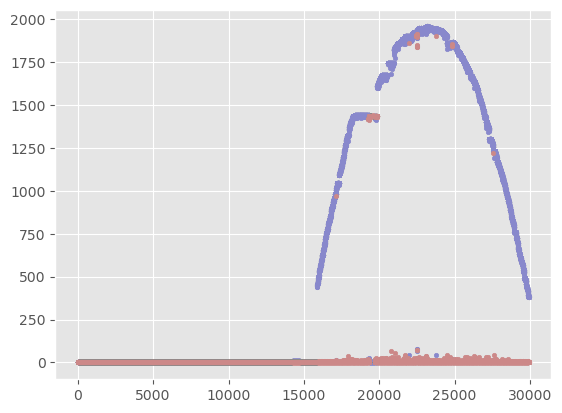

In [115]:
fig, ax = pyplot.subplots()
ax.scatter(range(0, di["Length"]["edge_61155"]), covs, color="#88c", s=10)
ax.scatter(range(0, di["Length"]["edge_61155"]), dels, color="#c88", s=10, zorder=1000)
# ax.set_yscale("symlog")

Length of edge_61155 is 29,909 bp; avg cov is 657.7800996355612x.
On 0-idx'd pos 0.
On 0-idx'd pos 10,000.
On 0-idx'd pos 20,000.
Done.


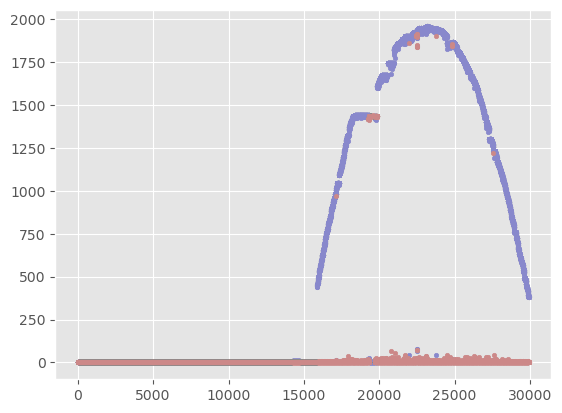

In [143]:
covs, dels = get_covs_and_dels("edge_61155", bam_fp="/Poppy/mfedarko/sheepgut/sf-analyses/sheep/output/aln/final.bam")
fig, ax = pyplot.subplots()
ax.scatter(range(0, di["Length"]["edge_61155"]), covs, color="#88c", s=10)
ax.scatter(range(0, di["Length"]["edge_61155"]), dels, color="#c88", s=10, zorder=1000)
# ax.set_yscale("symlog")

Length of edge_61155 is 29,909 bp; avg cov is 657.7800996355612x.
On 0-idx'd pos 0.
On 0-idx'd pos 10,000.
On 0-idx'd pos 20,000.
Done.


6089

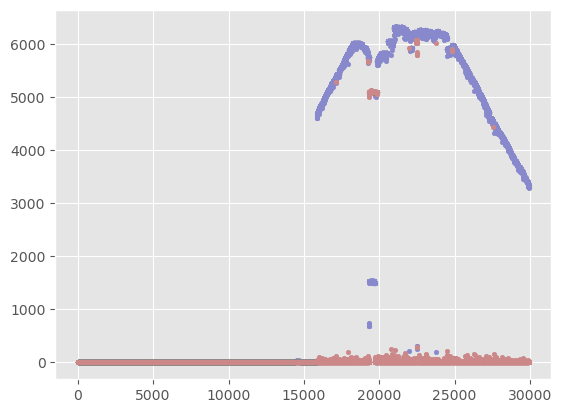

In [144]:
covs, dels = get_covs_and_dels("edge_61155", bam_fp="/Poppy/mfedarko/sheepgut/sf-analyses/sheep/output/aln/sorted-unfiltered.bam")
fig, ax = pyplot.subplots()
ax.scatter(range(0, di["Length"]["edge_61155"]), covs, color="#88c", s=10)
ax.scatter(range(0, di["Length"]["edge_61155"]), dels, color="#c88", s=10, zorder=1000)
max(dels)
# ax.set_yscale("symlog")

In [116]:
covs11863, dels11863 = get_covs_and_dels("edge_11863")

Length of edge_11863 is 2,597,011 bp; avg cov is 1,057.4117930189743x.
On 0-idx'd pos 0.
On 0-idx'd pos 10,000.
On 0-idx'd pos 20,000.
On 0-idx'd pos 30,000.
On 0-idx'd pos 40,000.
On 0-idx'd pos 50,000.
On 0-idx'd pos 60,000.
On 0-idx'd pos 70,000.
On 0-idx'd pos 80,000.
On 0-idx'd pos 90,000.
On 0-idx'd pos 100,000.
On 0-idx'd pos 110,000.
On 0-idx'd pos 120,000.
On 0-idx'd pos 130,000.
On 0-idx'd pos 140,000.
On 0-idx'd pos 150,000.
On 0-idx'd pos 160,000.
On 0-idx'd pos 170,000.
On 0-idx'd pos 180,000.
On 0-idx'd pos 190,000.
On 0-idx'd pos 200,000.
On 0-idx'd pos 210,000.
On 0-idx'd pos 220,000.
On 0-idx'd pos 230,000.
On 0-idx'd pos 240,000.
On 0-idx'd pos 250,000.
On 0-idx'd pos 260,000.
On 0-idx'd pos 270,000.
On 0-idx'd pos 280,000.
On 0-idx'd pos 290,000.
On 0-idx'd pos 300,000.
On 0-idx'd pos 310,000.
On 0-idx'd pos 320,000.
On 0-idx'd pos 330,000.
On 0-idx'd pos 340,000.
On 0-idx'd pos 350,000.
On 0-idx'd pos 360,000.
On 0-idx'd pos 370,000.
On 0-idx'd pos 380,000.
On 0-idx

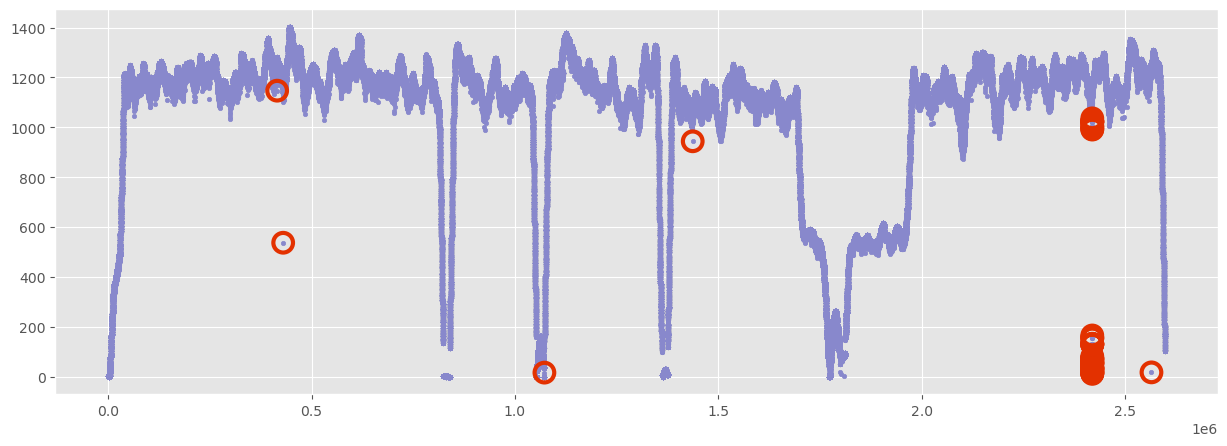

In [126]:
fig, ax = pyplot.subplots()
# same color used in notebooks/CoverageSkewPlots.ipynb
ax.scatter(range(1, di["Length"]["edge_11863"] + 1), covs11863, color="#348ABD", s=10)
# for pos, dels in enumerate(dels11863, 1):
#     if dels >= 100:
#         ax.scatter(pos, covs11863[pos - 1], 200, color="#e33100", facecolor="none", lw=3, zorder=999)
# ax.scatter(range(0, di["Length"]["edge_11863"]), dels11863, color="#c88", s=10, zorder=1000)

fig.set_size_inches(15, 5)
# ax.set_yscale("symlog")

In [127]:
covs4773, dels4773 = get_covs_and_dels("edge_4773")

Length of edge_4773 is 1,371,455 bp; avg cov is 1,176.24972747921x.
On 0-idx'd pos 0.
On 0-idx'd pos 10,000.
On 0-idx'd pos 20,000.
On 0-idx'd pos 30,000.
On 0-idx'd pos 40,000.
On 0-idx'd pos 50,000.
On 0-idx'd pos 60,000.
On 0-idx'd pos 70,000.
On 0-idx'd pos 80,000.
On 0-idx'd pos 90,000.
On 0-idx'd pos 100,000.
On 0-idx'd pos 110,000.
On 0-idx'd pos 120,000.
On 0-idx'd pos 130,000.
On 0-idx'd pos 140,000.
On 0-idx'd pos 150,000.
On 0-idx'd pos 160,000.
On 0-idx'd pos 170,000.
On 0-idx'd pos 180,000.
On 0-idx'd pos 190,000.
On 0-idx'd pos 200,000.
On 0-idx'd pos 210,000.
On 0-idx'd pos 220,000.
On 0-idx'd pos 230,000.
On 0-idx'd pos 240,000.
On 0-idx'd pos 250,000.
On 0-idx'd pos 260,000.
On 0-idx'd pos 270,000.
On 0-idx'd pos 280,000.
On 0-idx'd pos 290,000.
On 0-idx'd pos 300,000.
On 0-idx'd pos 310,000.
On 0-idx'd pos 320,000.
On 0-idx'd pos 330,000.
On 0-idx'd pos 340,000.
On 0-idx'd pos 350,000.
On 0-idx'd pos 360,000.
On 0-idx'd pos 370,000.
On 0-idx'd pos 380,000.
On 0-idx'd 

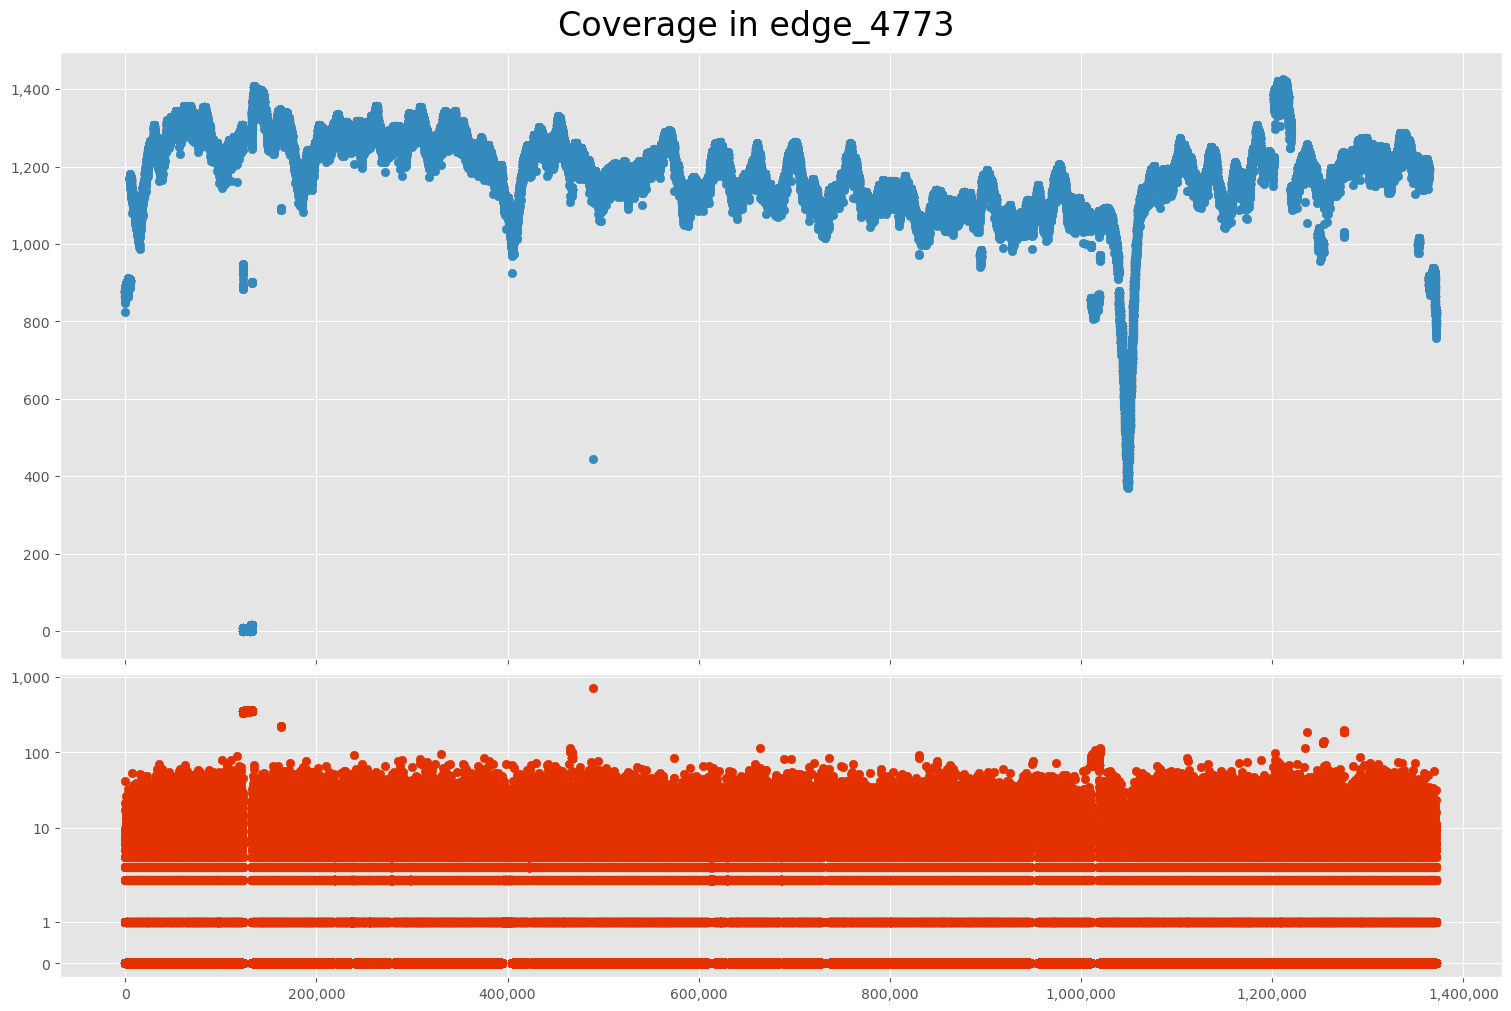

In [139]:
fig, axes = pyplot.subplot_mosaic(
    [
    [0],
    [0],
    [1],],
    sharex=True,
    constrained_layout=True
)
axes[0].scatter(range(1, di["Length"]["edge_4773"] + 1), covs4773, color="#348ABD")
axes[1].scatter(range(1, di["Length"]["edge_4773"] + 1), dels4773, color="#E33100")
axes[1].set_yscale("symlog")
# for pos, dels in enumerate(dels4773, 1):
#     if dels >= 100:
#         ax.scatter(pos, covs4773[pos - 1], 200, color="#e33100", facecolor="none", lw=3, zorder=999)
# ax.scatter(range(0, di["Length"]["edge_11863"]), dels11863, color="#c88", s=10, zorder=1000)
fig.suptitle("Coverage in edge_4773", fontsize=24)
axes[1].xaxis.set_major_formatter("{x:,.0f}")
axes[0].yaxis.set_major_formatter("{x:,.0f}")
axes[1].yaxis.set_major_formatter("{x:,.0f}")
fig.set_size_inches(15, 10)
# ax.set_yscale("symlog")

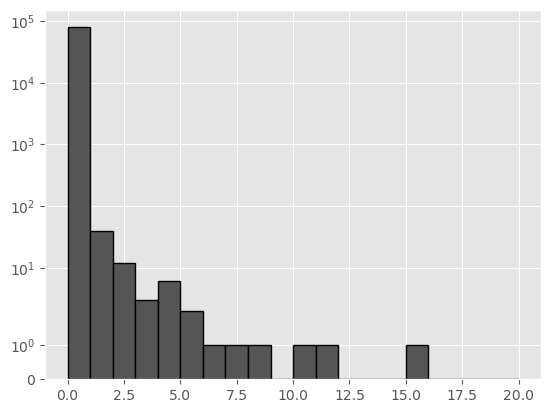

In [39]:
ratio = 100 * (cdf["100DelPos"] / di["Length"])
fig, ax = pyplot.subplots()
ax.hist(ratio, bins=range(0, 21), color="#555", linewidth=1, edgecolor="#000")
ax.set_yscale("symlog")

In [26]:
cdf["100DelPos"].max()

23481

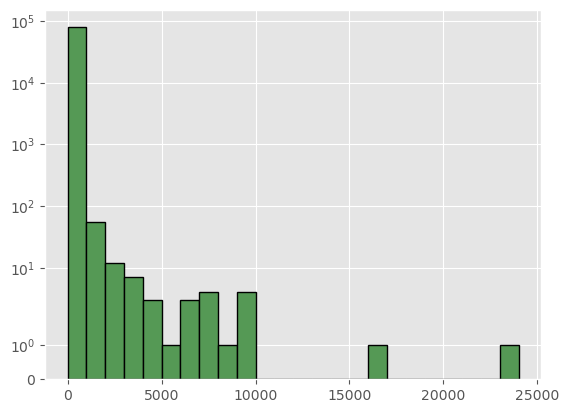

In [44]:
fig, ax = pyplot.subplots()
ax.hist(cdf["100DelPos"], bins=range(0, 25000, 1000), color="#595", linewidth=1, edgecolor="#000")
ax.set_yscale("symlog")

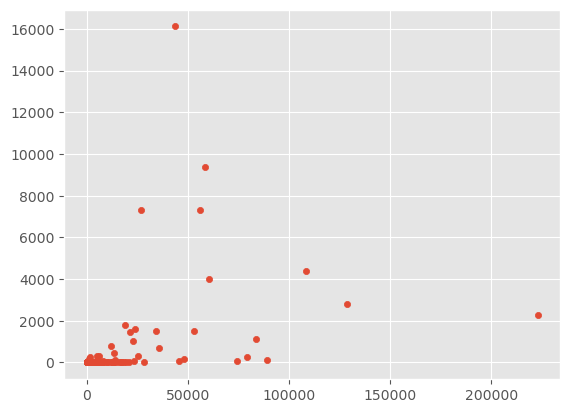

In [156]:
fig, ax = pyplot.subplots()
ax.scatter(cdf_long["10DelPos"], cdf_long["100DelPos"], s=20)
# ax.set_xscale("symlog")
# ax.set_yscale("symlog")